In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms
import scipy.stats
from math import ceil

A company want to test whether show a creative and interactive ad will increase the amount of questionnaire respond rate that they received

In [2]:
df=pd.read_csv('AdSmartABdata - AdSmartABdata.csv')

In [3]:
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


**Data Descriptions:**  
- auction_id: the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero  
- experiment: which group the user belongs to - control or exposed   
    > control: users who have been shown a dummy ad  
    > exposed: users who have been shown a creative, an online interactive ad, with the SmartAd brand    
- date: the date in YYYY-MM-DD format  
- hour: the hour of the day in HH format  
- device_make: the name of the type of device the user has e.g. Samsung  
- platform_os: the id of the OS the user has  
- browser: the name of the browser the user uses to see the BIO questionnaire  
- yes: 1 if the user chooses the “Yes” radio button for the BIO questionnaire  
- no: 1 if the user chooses the “No” radio button for the BIO questionnaire  

## Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


There's no missing value in each column

In [5]:
# change date datatype
df['date']=pd.to_datetime(df['date'])

In [6]:
# check if there's any duplicate record
df.duplicated().sum()

0

## Exploratory Data Analysis

In [7]:
df['experiment'].value_counts()/len(df)*100

control    50.402377
exposed    49.597623
Name: experiment, dtype: float64

There are more people in the control group than the exposed one. However, the gap is not that huge

In [8]:
df_control_subset=df[df['experiment']=='control']
df_exposed_subset=df[df['experiment']=='exposed']

In [9]:
df_control_subset[['device_make', 'browser']].describe().transpose()

,count,unique,top,freq
device_make,4071,168,Generic Smartphone,2411
browser,4071,12,Chrome Mobile,2410


In control group the most used device by user is generic smartphone, while the most used browser is chrome mobile

In [10]:
df_exposed_subset[['device_make', 'browser']].describe().transpose()

,count,unique,top,freq
device_make,4006,217,Generic Smartphone,2332
browser,4006,12,Chrome Mobile,2144


The same case also happen to exposed group

In [11]:
df.groupby(by='experiment', as_index=False)[['yes', 'no']].sum()

,experiment,yes,no
0,control,264,322
1,exposed,308,349


There 264 people and 322 people who responded yes and no in the questionnaire as the control group. Also, there 308 people and 349 people who responded yes and no as the exposed group. The rest is people who are not respond to the questionnaire

In [12]:
len(df[(df['yes']==0) & df['no']==0])

7406

To be exact there's 7406 people who didn't respond the questionnaire in both experiment group

## Exploratory Data Analysis : Identifying Trends

In [13]:
# break out the value of yes column by time and browser used
by_browser=pd.pivot_table(df,
                               values=['yes'], 
                               index=['date'],
                               columns=['browser'],
                               aggfunc='sum',
                               fill_value=0)
by_browser=by_browser.reset_index()
by_browser

date     yes                                             \
browser            Android Chrome Chrome Mobile Chrome Mobile WebView   
0       2020-07-03       0      0            74                    25   
1       2020-07-04       0      0            41                    16   
2       2020-07-05       0      1            28                    11   
3       2020-07-06       0      0            22                     6   
4       2020-07-07       0      0            24                     9   
5       2020-07-08       0      0            56                    16   
6       2020-07-09       0      0            44                    22   
7       2020-07-10       0      0            25                    11   

                                                                             \
browser Chrome Mobile iOS Edge Mobile Facebook Firefox Mobile Mobile Safari   
0                       0           0       23              0             0   
1                       1           0       11              0             1   
2                       0           0        6              0             1   
3                       0           0        3              0             0   
4                       0           0        3              0             0   
5                       0           0        7              0             0   
6                       0           0        6              0             2   
7                       0           0       10              0             0   

                                                                             \
browser Mobile Safari UI/WKWebView Opera Mini Opera Mobile Pinterest Puffin   
0                                0          0            0         0      0   
1                                0          0            0         0      0   
2                                0          0            0         0      0   
3                                0          0            0         0      0   
4                                0          0            0         0      0   
5                                0          0            0         0      0   
6                                0          0            0         0      0   
7                                0          0            0         0      0   

                          
browser Samsung Internet  
0                     25  
1                      6  
2                      5  
3                      4  
4                      2  
5                      6  
6                     11  
7                      8

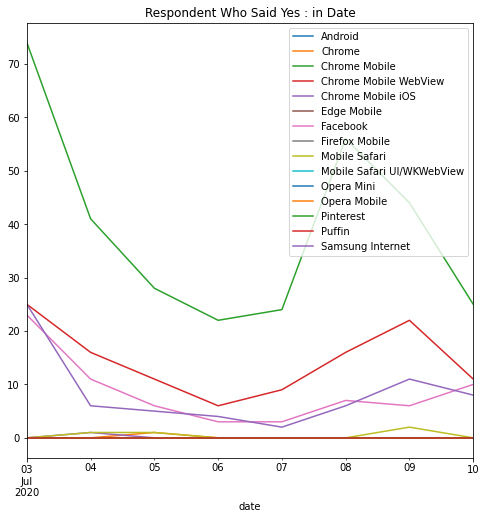

In [14]:
by_browser.plot(x='date', y='yes', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said Yes : in Date')
plt.show()

As known before, respondent who answer yes use chrome mobile the most. The peak of using happened at 8 July 2020

In [15]:
# break out the value of yes column by hour and browser used
by_browser1=pd.pivot_table(df,
                               values=['yes'], 
                               index=['hour'],
                               columns=['browser'],
                               aggfunc='sum',
                               fill_value=0)
by_browser1=by_browser1.reset_index()
by_browser1

hour     yes                                             \
browser      Android Chrome Chrome Mobile Chrome Mobile WebView   
0          0       0      0             6                     6   
1          1       0      0             7                     3   
2          2       0      0             7                     3   
3          3       0      0            10                     1   
4          4       0      0            14                     5   
5          5       0      0            10                     5   
6          6       0      0            17                     6   
7          7       0      0            12                     6   
8          8       0      0            13                    12   
9          9       0      0            15                     7   
10        10       0      0            13                     5   
11        11       0      0            10                     2   
12        12       0      1             8                     1   
13        13       0      0             9                     9   
14        14       0      0            12                     6   
15        15       0      0            67                     9   
16        16       0      0            17                     4   
17        17       0      0             9                     5   
18        18       0      0             8                     4   
19        19       0      0             9                     2   
20        20       0      0            17                     6   
21        21       0      0            14                     7   
22        22       0      0             6                     2   
23        23       0      0             4                     0   

                                                                             \
browser Chrome Mobile iOS Edge Mobile Facebook Firefox Mobile Mobile Safari   
0                       0           0        3              0             0   
1                       0           0        1              0             0   
2                       0           0        1              0             0   
3                       0           0        0              0             2   
4                       0           0        1              0             0   
5                       0           0        1              0             1   
6                       0           0        2              0             0   
7                       0           0        4              0             0   
8                       0           0        2              0             0   
9                       0           0        3              0             1   
10                      0           0        5              0             0   
11                      1           0        2              0             0   
12                      0           0        3              0             0   
13                      0           0        3              0             0   
14                      0           0        2              0             0   
15                      0           0       26              0             0   
16                      0           0        1              0             0   
17                      0           0        1              0             0   
18                      0           0        1              0             0   
19                      0           0        0              0             0   
20                      0           0        2              0             0   
21                      0           0        2              0             0   
22                      0           0        2              0             0   
23                      0           0        1              0             0   

                                                                             \
browser Mobile Safari UI/WKWebView Opera Mini Opera Mobile Pinterest Puffin   
0                                0          0       

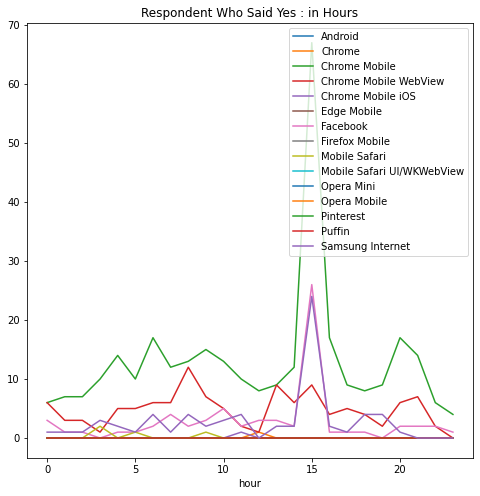

In [16]:
by_browser1.plot(x='hour', y='yes', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said Yes : in Hours')
plt.show()

Some browsers mostly used at 15 o'clock by respondent who answer yes

In [17]:
# break out the value of no column by date and browser used
by_browserno=pd.pivot_table(df,
                               values=['no'], 
                               index=['date'],
                               columns=['browser'],
                               aggfunc='sum',
                               fill_value=0)
by_browserno=by_browserno.reset_index()
by_browserno

date      no                                             \
browser            Android Chrome Chrome Mobile Chrome Mobile WebView   
0       2020-07-03       0      1           102                    23   
1       2020-07-04       0      0            46                    13   
2       2020-07-05       0      0            39                    14   
3       2020-07-06       0      0            21                     8   
4       2020-07-07       0      0            24                     8   
5       2020-07-08       0      0            48                    19   
6       2020-07-09       0      0            61                    13   
7       2020-07-10       0      0            40                    13   

                                                                             \
browser Chrome Mobile iOS Edge Mobile Facebook Firefox Mobile Mobile Safari   
0                       0           0       24              0             5   
1                       0           0       12              0             2   
2                       0           0        2              0             0   
3                       0           0        5              0             1   
4                       0           0        3              0             0   
5                       0           0       16              0             1   
6                       0           0       16              0             1   
7                       0           0        9              0             0   

                                                                             \
browser Mobile Safari UI/WKWebView Opera Mini Opera Mobile Pinterest Puffin   
0                                1          0            0         0      0   
1                                0          0            0         0      0   
2                                0          0            0         0      0   
3                                0          0            0         0      0   
4                                1          0            0         0      0   
5                                0          0            0         0      0   
6                                0          0            0         0      0   
7                                1          0            0         0      0   

                          
browser Samsung Internet  
0                     22  
1                     10  
2                     10  
3                      4  
4                      9  
5                      8  
6                      8  
7                      7

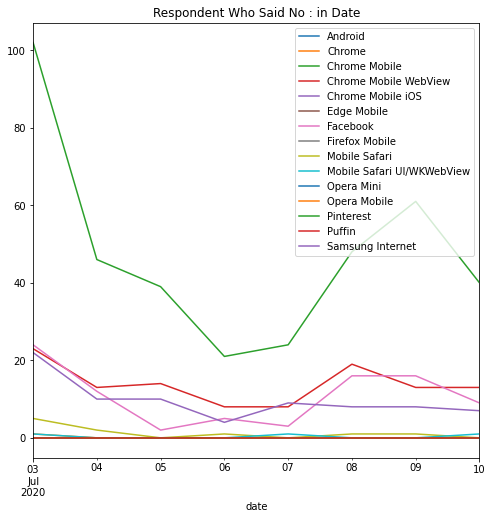

In [18]:
by_browserno.plot(x='date', y='no', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said No : in Date')
plt.show()

While respondent who said no mostly use chrome mobile at 9 July 2020

In [19]:
# break out the value of no column by hour and browser used
by_browserno1=pd.pivot_table(df,
                               values=['no'], 
                               index=['hour'],
                               columns=['browser'],
                               aggfunc='sum',
                               fill_value=0)
by_browserno1=by_browserno1.reset_index()
by_browserno1

hour      no                                             \
browser      Android Chrome Chrome Mobile Chrome Mobile WebView   
0          0       0      0             9                     3   
1          1       0      0            12                     2   
2          2       0      0            11                     4   
3          3       0      0            18                     5   
4          4       0      0            17                     5   
5          5       0      0            20                     4   
6          6       0      0            12                     6   
7          7       0      0            18                    10   
8          8       0      0            19                     8   
9          9       0      0            14                     7   
10        10       0      0            16                     9   
11        11       0      0            17                     4   
12        12       0      0            17                     4   
13        13       0      0             8                     4   
14        14       0      0            15                     5   
15        15       0      1            84                    14   
16        16       0      0            11                     5   
17        17       0      0            11                     3   
18        18       0      0            16                     2   
19        19       0      0            14                     3   
20        20       0      0             8                     2   
21        21       0      0             7                     1   
22        22       0      0             7                     1   
23        23       0      0             0                     0   

                                                                             \
browser Chrome Mobile iOS Edge Mobile Facebook Firefox Mobile Mobile Safari   
0                       0           0        2              0             0   
1                       0           0        1              0             1   
2                       0           0        3              0             1   
3                       0           0        2              0             0   
4                       0           0        2              0             0   
5                       0           0        2              0             1   
6                       0           0        3              0             0   
7                       0           0        3              0             0   
8                       0           0        3              0             1   
9                       0           0        3              0             0   
10                      0           0        5              0             0   
11                      0           0        1              0             1   
12                      0           0        4              0             1   
13                      0           0        4              0             0   
14                      0           0        4              0             0   
15                      0           0       26              0             3   
16                      0           0        2              0             0   
17                      0           0        1              0             0   
18                      0           0        3              0             0   
19                      0           0        2              0             1   
20                      0           0        6              0             0   
21                      0           0        2              0             0   
22                      0           0        3              0             0   
23                      0           0        0              0             0   

                                                                             \
browser Mobile Safari UI/WKWebView Opera Mini Opera Mobile Pinterest Puffin   
0                                0          0       

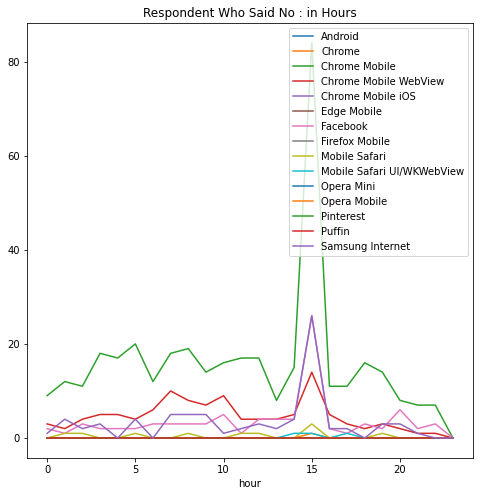

In [20]:
by_browserno1.plot(x='hour', y='no', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said No : in Hours')
plt.show()

Just like respondent who said yes, some browsers mostly used at 15 o'clock

In [21]:
# break out the value of yes column by time and device used
by_device=pd.pivot_table(df,
                        values=['yes'], 
                        index=['date'],
                        columns=['device_make'],
                        aggfunc='sum',
                        fill_value=0)
by_device=by_device.reset_index()
by_device

date       yes                                            \
device_make            5008Y_EEA 5099Y 6039Y A0001 ALE-L21 ANE-LX1 ATU-L11   
0           2020-07-03         0     0     0     1       0       1       0   
1           2020-07-04         0     0     0     0       0       1       0   
2           2020-07-05         0     0     0     0       0       0       0   
3           2020-07-06         0     0     0     0       0       0       0   
4           2020-07-07         0     0     0     0       0       0       0   
5           2020-07-08         0     0     0     0       0       0       0   
6           2020-07-09         0     0     0     0       0       0       0   
7           2020-07-10         0     0     0     0       0       1       0   

                                ...                          \
device_make Armor_3 Asus I01WD  ... XiaoMi Redmi Note 6 Pro   
0                 0          0  ...                       0   
1                 0          0  ...                       0   
2                 0          0  ...                       0   
3                 0          0  ...                       0   
4                 0          0  ...                       0   
5                 0          0  ...                       0   
6                 0          0  ...                       0   
7                 0          0  ...                       0   

                                                                             \
device_make XiaoMi Redmi Note 7 XiaoMi Redmi Note 8 XiaoMi Redmi Note 8 Pro   
0                             0                   0                       0   
1                             0                   0                       0   
2                             0                   0                       0   
3                             0                   0                       0   
4                             0                   0                       0   
5                             0                   0                       0   
6                             0                   0                       0   
7                             0                   0                       0   

                                                                              \
device_make XiaoMi Redmi Note 8T XiaoMi Redmi S2 YAL-L21 iPhone moto e5 play   
0                              0               0       0      0            0   
1                              0               0       0      2            0   
2                              0               0       0      1            0   
3                              0               0       0      0            0   
4                              0               0       0      0            0   
5                              0               0       0      0            0   
6                              0               0       1      2            0   
7                              0               1       0      0            0   

                          
device_make moto e5 plus  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
5                      0  
6                      0  
7                      0  

[8 rows x 270 columns]

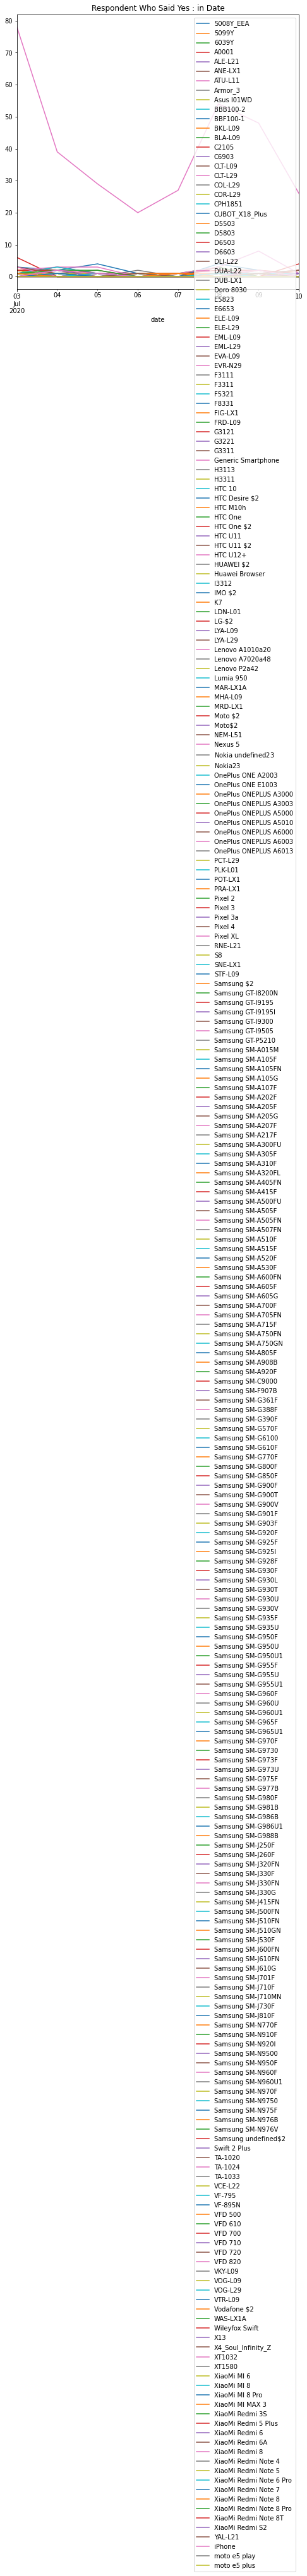

In [22]:
by_device.plot(x='date', y='yes', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said Yes : in Date')
plt.show()

There's huge a gap of amount between people who use generic smartphone and other devices. But most of the user responded yes in the questionnaire in 8 July 2020

In [23]:
# break out the value of yes column by hour and device used
by_device1=pd.pivot_table(df,
                               values=['yes'], 
                               index=['hour'],
                               columns=['device_make'],
                               aggfunc='sum',
                               fill_value=0)
by_device1=by_device1.reset_index()
by_device1

hour       yes                                                    \
device_make      5008Y_EEA 5099Y 6039Y A0001 ALE-L21 ANE-LX1 ATU-L11 Armor_3   
0              0         0     0     0     0       0       0       0       0   
1              1         0     0     0     0       0       0       0       0   
2              2         0     0     0     0       0       1       0       0   
3              3         0     0     0     0       0       0       0       0   
4              4         0     0     0     0       0       0       0       0   
5              5         0     0     0     0       0       0       0       0   
6              6         0     0     0     0       0       0       0       0   
7              7         0     0     0     0       0       0       0       0   
8              8         0     0     0     0       0       0       0       0   
9              9         0     0     0     1       0       0       0       0   
10            10         0     0     0     0       0       0       0       0   
11            11         0     0     0     0       0       0       0       0   
12            12         0     0     0     0       0       1       0       0   
13            13         0     0     0     0       0       0       0       0   
14            14         0     0     0     0       0       0       0       0   
15            15         0     0     0     0       0       1       0       0   
16            16         0     0     0     0       0       0       0       0   
17            17         0     0     0     0       0       0       0       0   
18            18         0     0     0     0       0       0       0       0   
19            19         0     0     0     0       0       0       0       0   
20            20         0     0     0     0       0       0       0       0   
21            21         0     0     0     0       0       0       0       0   
22            22         0     0     0     0       0       0       0       0   
23            23         0     0     0     0       0       0       0       0   

                        ...                                              \
device_make Asus I01WD  ... XiaoMi Redmi Note 6 Pro XiaoMi Redmi Note 7   
0                    0  ...                       0                   0   
1                    0  ...                       0                   0   
2                    0  ...                       0                   0   
3                    0  ...                       0                   0   
4                    0  ...                       0                   0   
5                    0  ...                       0                   0   
6                    0  ...                       0                   0   
7                    0  ...                       0                   0   
8                    0  ...                       0                   0   
9                    0  ...                       0                   0   
10                   0  ...                       0                   0   
11                   0  ...                       0                   0   
12                   0  ...                       0                   0   
13                   0  ...                       0                   0   
14                   0  ...                       0                   0   
15                   0  ...                       0                   0   
16                   0  ...                       0                   0   
17                   0  ...                       0                   0   
18                   0  ...                       0                   0   
19                   0  ...                       0                   0   
20                   0  ...                       0                   0   
21                   0  ...                       0                   0   
22                   0  ...                       0                   0   
23                   0  ...                       0     

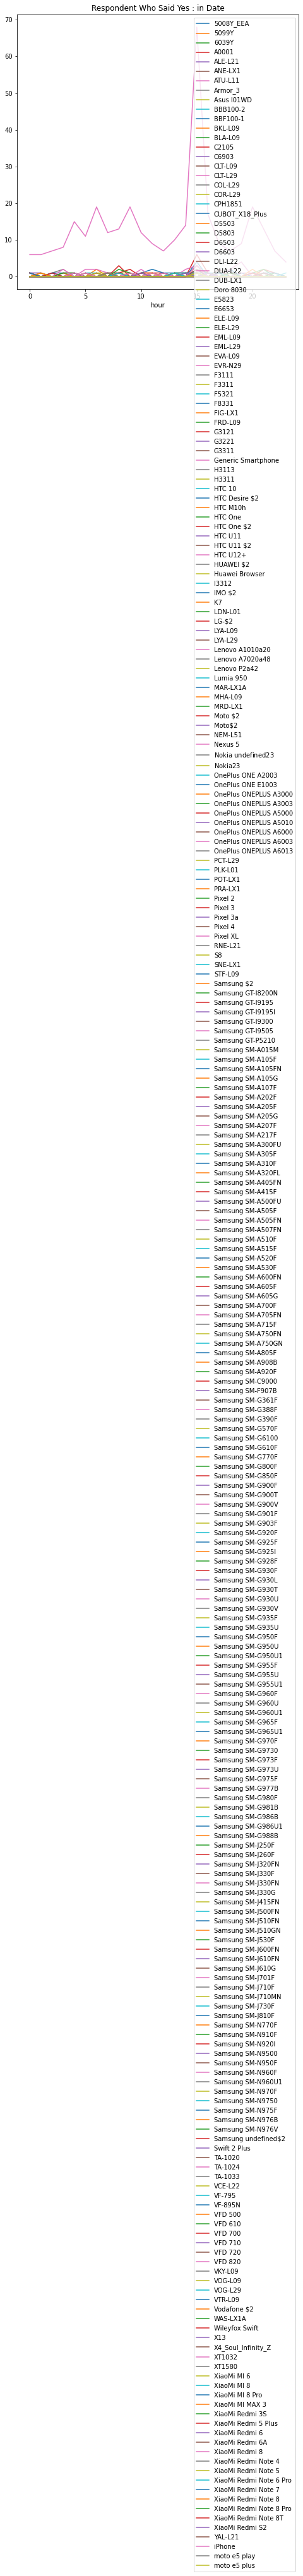

In [24]:
by_device1.plot(x='hour', y='yes', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said Yes : in Date')
plt.show()

There are some peaks in terms of hours for people who responded yes in the questionnaire for different devices. But mostly it happened at 15 o'clock

In [25]:
# break out the value of no column by date and device used
by_deviceno=pd.pivot_table(df,
                               values=['no'], 
                               index=['date'],
                               columns=['device_make'],
                               aggfunc='sum',
                               fill_value=0)
by_deviceno=by_deviceno.reset_index()
by_deviceno

date        no                                            \
device_make            5008Y_EEA 5099Y 6039Y A0001 ALE-L21 ANE-LX1 ATU-L11   
0           2020-07-03         0     0     0     0       0       1       0   
1           2020-07-04         0     0     0     0       0       2       0   
2           2020-07-05         0     0     0     0       0       0       0   
3           2020-07-06         0     0     0     0       0       0       0   
4           2020-07-07         0     0     0     0       0       0       0   
5           2020-07-08         0     0     0     0       0       0       0   
6           2020-07-09         0     0     0     0       0       0       0   
7           2020-07-10         0     0     0     0       0       0       0   

                                ...                          \
device_make Armor_3 Asus I01WD  ... XiaoMi Redmi Note 6 Pro   
0                 0          0  ...                       0   
1                 0          0  ...                       0   
2                 0          0  ...                       0   
3                 0          0  ...                       0   
4                 0          0  ...                       0   
5                 0          0  ...                       0   
6                 0          0  ...                       0   
7                 0          0  ...                       0   

                                                                             \
device_make XiaoMi Redmi Note 7 XiaoMi Redmi Note 8 XiaoMi Redmi Note 8 Pro   
0                             1                   0                       0   
1                             0                   0                       0   
2                             0                   0                       0   
3                             0                   0                       0   
4                             0                   0                       0   
5                             0                   0                       0   
6                             0                   0                       0   
7                             0                   0                       0   

                                                                              \
device_make XiaoMi Redmi Note 8T XiaoMi Redmi S2 YAL-L21 iPhone moto e5 play   
0                              0               0       0      6            0   
1                              0               0       0      2            0   
2                              0               0       0      0            0   
3                              0               0       0      1            0   
4                              0               0       0      1            0   
5                              0               0       0      1            0   
6                              0               0       0      1            0   
7                              0               0       0      1            0   

                          
device_make moto e5 plus  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
5                      0  
6                      0  
7                      0  

[8 rows x 270 columns]

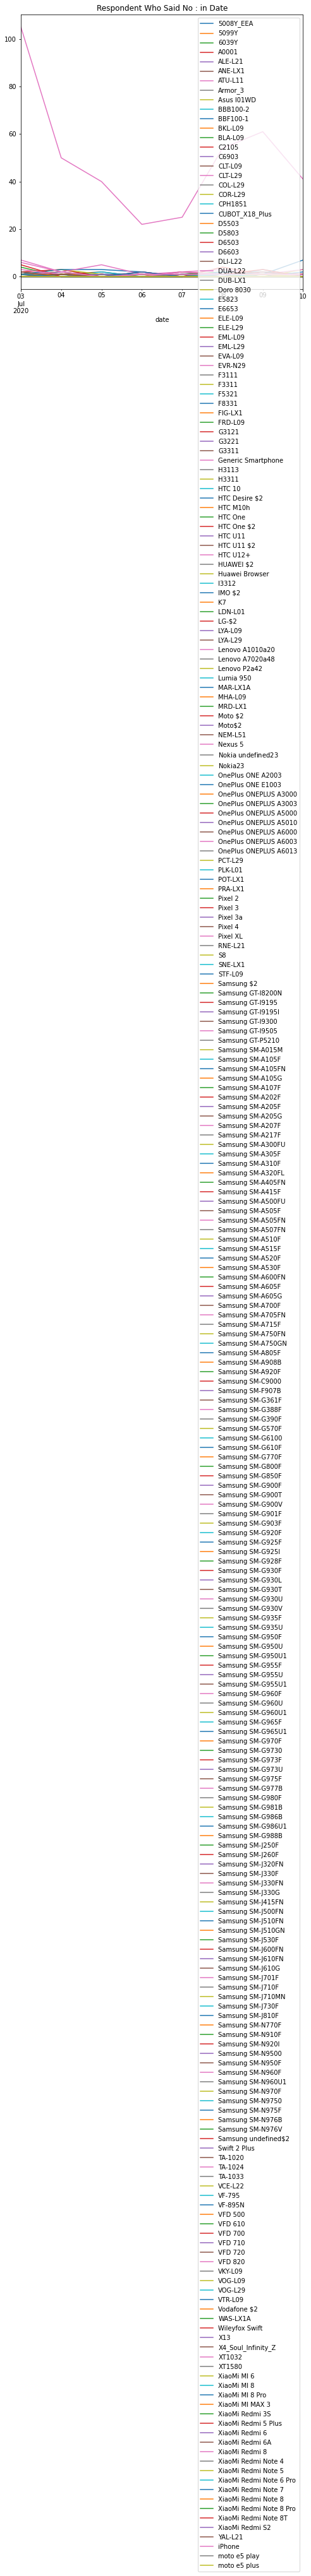

In [26]:
by_deviceno.plot(x='date', y='no', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said No : in Date')
plt.show()

Respondent who said no by their mostly choosen device which is generic smartphone, happened at 9 July 2020

In [27]:
# break out the value of no column by hour and device used
by_deviceno1=pd.pivot_table(df,
                               values=['no'], 
                               index=['hour'],
                               columns=['device_make'],
                               aggfunc='sum',
                               fill_value=0)
by_deviceno1=by_deviceno1.reset_index()
by_deviceno1

hour        no                                                    \
device_make      5008Y_EEA 5099Y 6039Y A0001 ALE-L21 ANE-LX1 ATU-L11 Armor_3   
0              0         0     0     0     0       0       0       0       0   
1              1         0     0     0     0       0       0       0       0   
2              2         0     0     0     0       0       0       0       0   
3              3         0     0     0     0       0       0       0       0   
4              4         0     0     0     0       0       0       0       0   
5              5         0     0     0     0       0       0       0       0   
6              6         0     0     0     0       0       0       0       0   
7              7         0     0     0     0       0       0       0       0   
8              8         0     0     0     0       0       0       0       0   
9              9         0     0     0     0       0       0       0       0   
10            10         0     0     0     0       0       1       0       0   
11            11         0     0     0     0       0       0       0       0   
12            12         0     0     0     0       0       1       0       0   
13            13         0     0     0     0       0       0       0       0   
14            14         0     0     0     0       0       0       0       0   
15            15         0     0     0     0       0       1       0       0   
16            16         0     0     0     0       0       0       0       0   
17            17         0     0     0     0       0       0       0       0   
18            18         0     0     0     0       0       0       0       0   
19            19         0     0     0     0       0       0       0       0   
20            20         0     0     0     0       0       0       0       0   
21            21         0     0     0     0       0       0       0       0   
22            22         0     0     0     0       0       0       0       0   
23            23         0     0     0     0       0       0       0       0   

                        ...                                              \
device_make Asus I01WD  ... XiaoMi Redmi Note 6 Pro XiaoMi Redmi Note 7   
0                    0  ...                       0                   0   
1                    0  ...                       0                   0   
2                    0  ...                       0                   0   
3                    0  ...                       0                   0   
4                    0  ...                       0                   0   
5                    0  ...                       0                   0   
6                    0  ...                       0                   0   
7                    0  ...                       0                   0   
8                    0  ...                       0                   0   
9                    0  ...                       0                   0   
10                   0  ...                       0                   0   
11                   0  ...                       0                   0   
12                   0  ...                       0                   0   
13                   0  ...                       0                   0   
14                   0  ...                       0                   0   
15                   0  ...                       0                   1   
16                   0  ...                       0                   0   
17                   0  ...                       0                   0   
18                   0  ...                       0                   0   
19                   0  ...                       0                   0   
20                   0  ...                       0                   0   
21                   0  ...                       0                   0   
22                   0  ...                       0                   0   
23                   0  ...                       0     

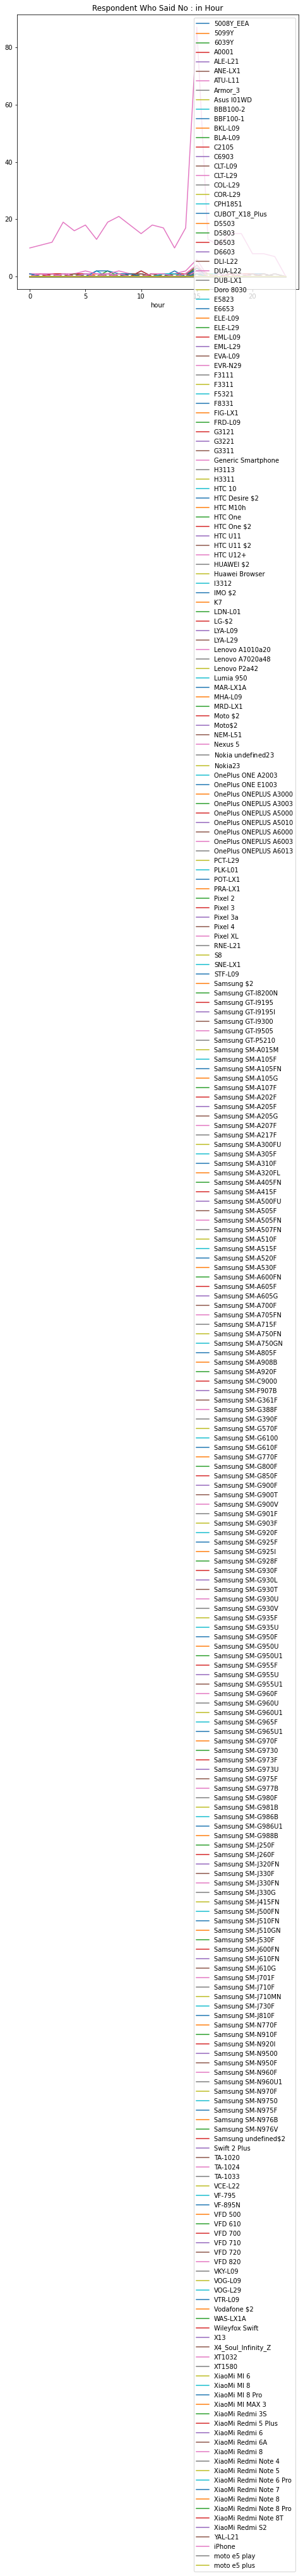

In [28]:
by_deviceno1.plot(x='hour', y='no', figsize=(8,8))
plt.legend(loc=1)
plt.title('Respondent Who Said No : in Hour')
plt.show()

Respondent who said no and using generic smartphone, responded mostly at 15 o'clock

## A/B Testing  
### Which group experiment has a higher respond rate?

Hypothesis:  
H0 : control and exposed has same or similar respond rate  
H1 : exposed will have higher respond rate than control ones

Hypothesis created to ensure the interpretation of the result is correct

### Choosing Sample Size

In [71]:
control_respondents=df[df['experiment']=='control']
conversion_control=control_respondents['yes'].sum()+control_respondents['no'].sum()
total_respondents_control=len(control_respondent)

exposed_respondents=df[df['experiment']=='exposed']
conversion_exposed=exposed_respondents['yes'].sum()+exposed_respondents['no'].sum()
total_respondents_exposed=len(exposed_respondents)

#count number of respondents who converted in each group
print('Number of control respondents who have been shown a dummy ad: ', conversion_control)
print('Percentage of control group respond rate: ', round((conversion_control / total_respondents_control) * 100, 2), '%')

print()

print('Number of exposed respondents who have been shown a creative, an online interactive ad, with the SmartAd brand: ', conversion_exposed)
print('Percentage of exposed group respond rate: ', round((conversion_exposed / total_respondents_exposed) * 100, 2), '%')

Number of control respondents who have been shown a dummy ad:  586
Percentage of control group respond rate:  14.39 %

Number of exposed respondents who have been shown a creative, an online interactive ad, with the SmartAd brand:  657
Percentage of exposed group respond rate:  16.4 %


In [40]:
baseline_rate=round(conversion_control/total_respondents_control,2)
baseline_rate

0.14

Let just say the marketing team want increasement of respond rate from **14%** to **16%**

The sample size we need is estimated through something called **Power analysis**, and it depends on a few factors:  
- Power of the test/sensitivity ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention
- Alpha value - The critical value we set to 0.05  
- Effect size - How big of a difference we expect there to be between the conversion rates

In [66]:
effect_size = sms.proportion_effectsize(0.14, 0.16)
sample_size=sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, # user defined
    alpha=0.05, # user defined, for a 95% confidence interval 
    ratio=1
    )

sample_size=ceil(sample_size)

print('Required sample size: ', round(sample_size), ' per group')

Required sample size:  4999  per group


We need at least 4999 respondents for each group

### Sampling

In [64]:
len(df)

8077

In [67]:
control_group = df[df['experiment'] == 'control']
exposed_group = df[df['experiment'] == 'exposed']

In [69]:
print('length of control group:' , len(control_group))
print('length of exposed group' , len(exposed_group))

length of control group: 4071
length of exposed group 4006


Since the length of the data for both group is less than required sample, then sampling is not undertaken. In fact, the amount of data could be added to increase the analysis robustness

### Testing hypothesis

Since the dataset is quite small t-test independent is undertaken to testing the hypotesis

In [90]:
df['respond_rate']=df['yes']+df['no']

In [99]:
from scipy.stats import ttest_ind
result = list(ttest_ind(
    df[df['experiment'] == 'control']['respond_rate'], 
     df[df['experiment'] == 'exposed']['respond_rate'],
    equal_var = False
))

In [100]:
result

[-2.497441364692631, 0.012529159055431248]

In [101]:
print('T-Statistic:', result[0])
print('P-Value:', result[1])

T-Statistic: -2.497441364692631
P-Value: 0.012529159055431248


In [102]:
result[1]<0.05

True

**Summary**  
The P-value is lower than our significant level 0.05, it means we have enough evidence to reject the Null Hypothesis. So, respondents who shown the creative, an online interactive ad, with the SmartAd brand or respondents in the exposed group will have higher respond rate than the control ones or people who shown the dummy ad